# parkinsons-detection

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import seaborn as sns
from time import time
from math import sqrt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ModuleNotFoundError: No module named 'matplotlib'

#### Timing decorator

In [2]:
def timeit(fn):
    def wrapper(*args, **kwargs):
        start=time()
        res=fn(*args, **kwargs)
        print(fn.__name__, "took", time()-start, "seconds.")
        return res
    return wrapper

## Data paths

In [3]:
control_data_path=os.path.join('data', 'control')
parkinson_data_path=os.path.join('data', 'parkinson')

NameError: name 'os' is not defined

In [4]:
control_file_list=[os.path.join(control_data_path, x) for x in os.listdir(control_data_path)]
parkinson_file_list=[os.path.join(parkinson_data_path, x) for x in os.listdir(parkinson_data_path)]

NameError: name 'os' is not defined

### Features
1. No of strokes
2. Stroke speed
3. Velocity
4. Acceleration
5. Jerk
6. Horizontal velocity/acceleration/jerk
7. Vertical velocity/acceleration/jerk
8. Number of changes in velocity direction
9. Number of changes in acceleration direction
10. Relative NCV
11. Relative NCA
12. in-air time
13. on-surface time
14. normalized in-air time
15. normalized on-surface time
16. in-air/on-surface ratio

## Feature Extraction

In [5]:
header_row=["X", "Y", "Z", "Pressure" , "GripAngle" , "Timestamp" , "Test_ID"]

In [6]:
#@timeit
def get_no_strokes(df):
    pressure_data=df['Pressure'].as_matrix()
    on_surface = (pressure_data>600).astype(int)
    return ((np.roll(on_surface, 1) - on_surface) != 0).astype(int).sum()

In [8]:
#@timeit
def get_speed(df):
    total_dist=0
    duration=df['Timestamp'].as_matrix()[-1]
    coords=df[['X', 'Y', 'Z']].as_matrix()
    for i in range(10, df.shape[0]):
        temp=np.linalg.norm(coords[i, :]-coords[i-10, :])
        total_dist+=temp
    speed=total_dist/duration
    return speed

In [9]:
#@timeit
def get_in_air_time(data):
    data=data['Pressure'].as_matrix()
    return (data<600).astype(int).sum()

In [10]:
#@timeit
def get_on_surface_time(data):
    data=data['Pressure'].as_matrix()
    return (data>600).astype(int).sum()

In [11]:
def find_velocity(f):
    '''
    change in direction and its position
    
    '''
    data_pat=f
    Vel = []
    horz_Vel = []
    horz_vel_mag = []
    vert_vel_mag = []
    vert_Vel = []
    magnitude = []
    timestamp_diff =  []
    
    t = 0
    for i in range(len(data_pat)-2):
        if t+10 <= len(data_pat)-1:
            Vel.append(((data_pat['X'].as_matrix()[t+10] - data_pat['X'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t]) , (data_pat['Y'].as_matrix()[t+10]-data_pat['Y'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t])))
            horz_Vel.append((data_pat['X'].as_matrix()[t+10] - data_pat['X'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t]))
            
            vert_Vel.append((data_pat['Y'].as_matrix()[t+10] - data_pat['Y'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t]))
            magnitude.append(sqrt(((data_pat['X'].as_matrix()[t+10]-data_pat['X'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t]))**2 + (((data_pat['Y'].as_matrix()[t+10]-data_pat['Y'].as_matrix()[t])/(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t]))**2)))
            timestamp_diff.append(data_pat['Timestamp'].as_matrix()[t+10]-data_pat['Timestamp'].as_matrix()[t])
            horz_vel_mag.append(abs(horz_Vel[len(horz_Vel)-1]))
            vert_vel_mag.append(abs(vert_Vel[len(vert_Vel)-1]))
            t = t+10
        else:
            break
    magnitude_vel = np.mean(magnitude)  
    magnitude_horz_vel = np.mean(horz_vel_mag)
    magnitude_vert_vel = np.mean(vert_vel_mag)
    return Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel

In [12]:
def find_acceleration(f):
    '''
    change in direction and its velocity
   
    '''
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(f)
    accl = []
    horz_Accl =  []
    vert_Accl = []
    magnitude = []
    horz_acc_mag = []
    vert_acc_mag = []
    for i in range(len(Vel)-2):
        accl.append(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i] , (Vel[i+1][1]-Vel[i][1])/timestamp_diff[i]))
        horz_Accl.append((horz_Vel[i+1]-horz_Vel[i])/timestamp_diff[i])
        vert_Accl.append((vert_Vel[i+1]-vert_Vel[i])/timestamp_diff[i])
        horz_acc_mag.append(abs(horz_Accl[len(horz_Accl)-1]))
        vert_acc_mag.append(abs(vert_Accl[len(vert_Accl)-1]))
        magnitude.append(sqrt(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i])**2 + ((Vel[i+1][1]-Vel[i][1])/timestamp_diff[i])**2))
    
    magnitude_acc = np.mean(magnitude)  
    magnitude_horz_acc = np.mean(horz_acc_mag)
    magnitude_vert_acc = np.mean(vert_acc_mag)
    return accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc
    

In [13]:
def find_jerk(f):
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc = find_acceleration(f)
    jerk = []
    hrz_jerk = []
    vert_jerk = []
    magnitude = []
    horz_jerk_mag = []
    vert_jerk_mag = []
    
    for i in range(len(accl)-2):
        jerk.append(((accl[i+1][0]-accl[i][0])/timestamp_diff[i] , (accl[i+1][1]-accl[i][1])/timestamp_diff[i]))
        hrz_jerk.append((horz_Accl[i+1]-horz_Accl[i])/timestamp_diff[i])
        vert_jerk.append((vert_Accl[i+1]-vert_Accl[i])/timestamp_diff[i])
        horz_jerk_mag.append(abs(hrz_jerk[len(hrz_jerk)-1]))
        vert_jerk_mag.append(abs(vert_jerk[len(vert_jerk)-1]))
        magnitude.append(sqrt(((accl[i+1][0]-accl[i][0])/timestamp_diff[i])**2 + ((accl[i+1][1]-accl[i][1])/timestamp_diff[i])**2))
        
    magnitude_jerk = np.mean(magnitude)  
    magnitude_horz_jerk = np.mean(horz_jerk_mag)
    magnitude_vert_jerk = np.mean(vert_jerk_mag)
    return jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk


In [14]:
def NCV_per_halfcircle(f):
    data_pat=f
    Vel = []
    ncv = []
    temp_ncv = 0
    basex = data_pat['X'].as_matrix()[0]
    for i in range(len(data_pat)-2):
        if data_pat['X'].as_matrix()[i] == basex:
            ncv.append(temp_ncv)
            temp_ncv = 0
            continue
            
        Vel.append(((data_pat['X'].as_matrix()[i+1] - data_pat['X'].as_matrix()[i])/(data_pat['Timestamp'].as_matrix()[i+1]-data_pat['Timestamp'].as_matrix()[i]) , (data_pat['Y'].as_matrix()[i+1]-data_pat['Y'].as_matrix()[i])/(data_pat['Timestamp'].as_matrix()[i+1]-data_pat['Timestamp'].as_matrix()[i])))
        if Vel[len(Vel)-1] != (0,0):
            temp_ncv+=1
    ncv.append(temp_ncv)
    #ncv = list(filter((2).__ne__, ncv))
    ncv_Val = np.sum(ncv)/np.count_nonzero(ncv)
    return ncv,ncv_Val

In [15]:
def NCA_per_halfcircle(f):
    data_pat=f
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(f)
    accl = []
    nca = []
    temp_nca = 0
    basex = data_pat['X'].as_matrix()[0]
    for i in range(len(Vel)-2):
        if data_pat['X'].as_matrix()[i] == basex:
            nca.append(temp_nca)
            #print ('tempNCa::',temp_nca)
            temp_nca = 0
            continue
            
        accl.append(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i] , (Vel[i+1][1]-Vel[i][1])/timestamp_diff[i]))
        if accl[len(accl)-1] != (0,0):
            temp_nca+=1
    nca.append(temp_nca)
    nca = list(filter((2).__ne__, nca))
    nca_Val = np.sum(nca)/np.count_nonzero(nca)
    return nca,nca_Val

In [16]:
#@timeit
def get_features(f, parkinson_target):
    global header_row
    df=pd.read_csv(f, sep=';', header=None, names=header_row)
    
    df_static=df[df["Test_ID"]==0]    # static test
    df_dynamic=df[df["Test_ID"]==1]    # dynamic test
    df_stcp=df[df["Test_ID"]==2]    # STCP
    #df_static_dynamic=pd.concat([df_static, df_dynamic])
    
    initial_timestamp=df['Timestamp'][0]
    df['Timestamp']=df['Timestamp']- initial_timestamp # offset timestamps
    
    duration_static = df_static['Timestamp'].as_matrix()[-1] if df_static.shape[0] else 1
    duration_dynamic = df_dynamic['Timestamp'].as_matrix()[-1] if df_dynamic.shape[0] else 1
    duration_STCP = df_stcp['Timestamp'].as_matrix()[-1] if df_stcp.shape[0] else 1

    
    data_point=[]
    data_point.append(get_no_strokes(df_static) if df_static.shape[0] else 0) # no. of strokes for static test
    data_point.append(get_no_strokes(df_dynamic) if df_dynamic.shape[0] else 0) # no. of strokes for dynamic test
    data_point.append(get_speed(df_static) if df_static.shape[0] else 0) # speed for static test
    data_point.append(get_speed(df_dynamic) if df_dynamic.shape[0] else 0) # speed for dynamic test

    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of velocity, horizontal velocity and vertical velocity for static test
    data_point.extend([magnitude_vel, magnitude_horz_vel,magnitude_vert_vel])
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of velocity, horizontal velocity and vertical velocity for dynamic test
    data_point.extend([magnitude_vel, magnitude_horz_vel,magnitude_vert_vel])
    
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc=find_acceleration(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0)# magnitudes of acceleration, horizontal acceleration and vertical acceleration for static test        
    data_point.extend([magnitude_acc,magnitude_horz_acc,magnitude_vert_acc])
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc=find_acceleration(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0)# magnitudes of acceleration, horizontal acceleration and vertical acceleration for dynamic test        
    data_point.extend([magnitude_acc,magnitude_horz_acc,magnitude_vert_acc])
    
    jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk=find_jerk(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of jerk, horizontal jerk and vertical jerk for static test
    data_point.extend([magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk])
    jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk=find_jerk(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of jerk, horizontal jerk and vertical jerk for dynamic test
    data_point.extend([magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk])
    
    ncv,ncv_Val=NCV_per_halfcircle(df_static) if df_static.shape[0] else (0,0) # NCV for static test
    data_point.append(ncv_Val)
    ncv,ncv_Val=NCV_per_halfcircle(df_dynamic) if df_dynamic.shape[0] else (0,0) # NCV for dynamic test
    data_point.append(ncv_Val)
    
    nca,nca_Val=NCA_per_halfcircle(df_static) if df_static.shape[0] else (0,0) # NCA for static test
    data_point.append(nca_Val)
    nca,nca_Val=NCA_per_halfcircle(df_dynamic) if df_dynamic.shape[0] else (0,0) # NCA for dynamic test
    data_point.append(nca_Val)
    
    data_point.append(get_in_air_time(df_stcp) if df_stcp.shape[0] else 0) # in air time for STCP
    data_point.append(get_on_surface_time(df_static) if df_static.shape[0] else 0) # on surface time for static test
    data_point.append(get_on_surface_time(df_dynamic) if df_dynamic.shape[0] else 0) # on surface time for dynamic test
    
    data_point.append(parkinson_target)    # traget. 1 for parkinson. 0 for control.
    
    return data_point

In [112]:
temp_feat=get_features(parkinson_file_list[35], 1)

In [18]:
print(temp_feat)

[38, 0, 0.005165936568903718, 0.00519496319538465, 0.04756128150602929, 0.03048896156117163, 0.030029416243858256, 0.06395426436269759, 0.04096324920500745, 0.04105515973647842, 0.0001644615587697484, 9.982923938565367e-05, 0.00010040116645599074, 0.00018235544822107173, 0.00011271810089934872, 0.00011244023558596647, 3.0565965831228398e-06, 1.9012707898320878e-06, 1.9337855679736854e-06, 3.2455975229629545e-06, 2.0664557939757304e-06, 2.04175146150256e-06, 363.3333333333333, 444.4, 199.0, 329.0, 1733, 26, 0, 1]


In [113]:
raw=[]
for x in parkinson_file_list:
    raw.append(get_features(x, 1))
for x in control_file_list:
    raw.append(get_features(x, 0))

In [114]:
raw=np.array(raw)

In [115]:
features_headers=['no_strokes_st', 'no_strokes_dy', 'speed_st', 'speed_dy', 'magnitude_vel_st' , 'magnitude_horz_vel_st' , 'magnitude_vert_vel_st', 'magnitude_vel_dy', 'magnitude_horz_vel_dy' , 'magnitude_vert_vel_dy', 'magnitude_acc_st' , 'magnitude_horz_acc_st' , 'magnitude_vert_acc_st','magnitude_acc_dy' , 'magnitude_horz_acc_dy' , 'magnitude_vert_acc_dy', 'magnitude_jerk_st', 'magnitude_horz_jerk_st' , 'magnitude_vert_jerk_st', 'magnitude_jerk_dy', 'magnitude_horz_jerk_dy' , 'magnitude_vert_jerk_dy', 'ncv_st', 'ncv_dy', 'nca_st', 'nca_dy', 'in_air_stcp','on_surface_st', 'on_surface_dy', 'target']

In [116]:
data=pd.DataFrame(raw, columns=features_headers)

In [117]:
data.tail()

,no_strokes_st,no_strokes_dy,speed_st,speed_dy,magnitude_vel_st,magnitude_horz_vel_st,magnitude_vert_vel_st,magnitude_vel_dy,magnitude_horz_vel_dy,magnitude_vert_vel_dy,...,magnitude_horz_jerk_dy,magnitude_vert_jerk_dy,ncv_st,ncv_dy,nca_st,nca_dy,in_air_stcp,on_surface_st,on_surface_dy,target
72,2.0,2.0,0.001592,0.001560,0.046842,0.029474,0.029731,0.042719,0.026828,0.026851,...,0.000004,0.000004,330.571429,324.571429,275.500000,282.000000,1536.0,5867.0,6558.0,0.0
73,2.0,2.0,0.001387,0.001339,0.088510,0.055965,0.055433,0.114583,0.073060,0.070357,...,0.000006,0.000005,224.222222,227.125000,71.500000,73.666667,1536.0,3029.0,2312.0,0.0
74,0.0,0.0,0.001152,0.001140,0.103493,0.066596,0.064488,0.106868,0.068777,0.067774,...,0.000005,0.000006,277.285714,266.285714,81.333333,117.000000,1536.0,0.0,0.0,0.0
75,6.0,2.0,0.003287,0.003390,0.040421,0.025278,0.025403,0.038332,0.023919,0.023961,...,0.000004,0.000004,283.000000,325.714286,205.000000,345.500000,1536.0,6746.0,7325.0,0.0
76,2.0,2.0,0.000012,0.000012,0.113848,0.073049,0.070813,0.102064,0.063312,0.065009,...,0.000005,0.000005,303.500000,261.285714,112.500000,120.500000,0.0,2413.0,2569.0,0.0


In [118]:
data.to_csv('data.csv')

In [119]:
print('data shape', data.shape)

data shape (77, 30)


## Classification

In [136]:
pos=data[data['target']==1]
neg=data[data['target']==0]

train_pos=pos.head(pos.shape[0]-5)
train_neg=neg.head(neg.shape[0]-5)
train=pd.concat([train_pos, train_neg])
print('train shape', train.shape)

test_pos=pos.tail(5)
test_neg=neg.tail(5)
test=pd.concat([test_pos, test_neg])


train_y=train['target']
train_x=train.drop(['target'], axis=1)
test_y=test['target']
test_x=test.drop(['target'], axis=1)


train shape (67, 30)


In [152]:
def accuracy(prediction,actual):
    correct = 0
    not_correct = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i]:
            correct+=1
        else:
            not_correct+=1
    return (correct*100)/(correct+not_correct)

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

### Logistic Regression

In [154]:
clf=LogisticRegression()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')

accuracy: 40.0 %


### Random Forest

In [155]:
clf=RandomForestClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')

accuracy: 70.0 %


### Support Vector Machine

In [156]:
clf=SVC()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')

accuracy: 50.0 %


### Decision Tree

In [157]:
clf=DecisionTreeClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')

accuracy: 100.0 %


### K-Nearest Neighbors

In [158]:
clf=KNeighborsClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')

accuracy: 40.0 %


## Some Plots

In [159]:
def plot(f, plot_func, t_id=0, x=None, y=None):
    global header_row
    df=pd.read_csv(f, sep=';', header=None, names=header_row)
    df=df[df["Test_ID"]==t_id]
    initial_timestamp=df['Timestamp'][0]
    df['Timestamp']=df['Timestamp']- initial_timestamp
    plot_func(data=df, x=x, y=y, fit_reg=False, scatter_kws={"s": 0.5})
    print(metrics(test_y.tolist(), preds.tolist()))

#### Pressure (Parkinsons)

{'Precision': 0.3, 'Recall': 0.42857142857142855, 'F1': 0.3529411764705882}


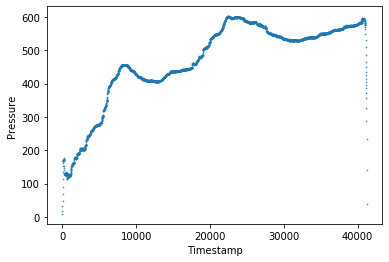

In [160]:
plot(parkinson_file_list[35],  plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')

#### Pressure (Control)

{'Precision': 0.3, 'Recall': 0.42857142857142855, 'F1': 0.3529411764705882}


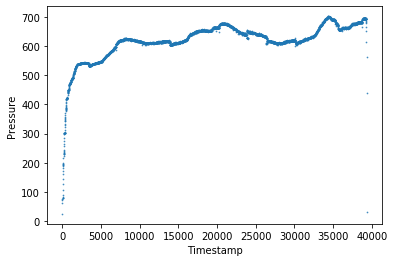

In [146]:
plot(control_file_list[1], plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')

In [147]:
clf=LogisticRegression()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
pd.crosstab(test_y, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0.0,1.0
Actual Result,,
0.0,0,5
1.0,1,4


In [148]:
clf=RandomForestClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
pd.crosstab(test_y, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0.0,1.0
Actual Result,,
0.0,4,1
1.0,0,5


In [149]:
clf=SVC()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
pd.crosstab(test_y, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,1.0
Actual Result,
0.0,5
1.0,5


In [150]:
clf=DecisionTreeClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
pd.crosstab(test_y, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0.0,1.0
Actual Result,,
0.0,5,0
1.0,0,5


In [151]:
clf=KNeighborsClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
pd.crosstab(test_y, preds, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0.0,1.0
Actual Result,,
0.0,1,4
1.0,2,3
